# <ins>Convolutional Neural Networks (CNNs) for Image Classification, and comparison of CPU vs GPU parallel processes</ins>

In [49]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [50]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## <ins>Introduction</ins>

In this report, we train a convolutional neural network (CNN) for image classification. An appropriate dataset was chosen, and the CNN was trained to classify images from this dataset. Initially, we train a very simple model which has an test accuracy of about 60%. Next, we improve the model, and see the accuracy improve to around 70%. Finally, we implement a smarter, and more complex model called ResNet. This increases the accuracy to over 80%. That is, where the initial 'simple' model fell short, we explored multiple new implimentations. We also examine the mathematics behind CNNs.

The question we aim to look at is: Can we use the parallel computation processes in GPUs to increase the training speed of convolutional neural networks, allowing us to train more complex (and therefore more accurarte) models?

We tackle this problem in depth, by using many examples. What we find is that the answer is yes. We compare the runtime of the model when varying parameters that lead to increased computation. The operations involved in CNNs are mainly matrix (or tensor) operations; therefore, we perform experiments to see how the GPU - due to its architure of allowing many parallel processes - fares better than the CPU at these operations.

In this project, we also delve deeply into how the convolutional neural works, and we also inspect the mathematics behind some of the functions and operations involed. We use the package PyTorch - a vital python tool for performing machine learning.

## <ins>CIFAR-10 – the dataset</ins>

In this project, we used the CIFAR-10 dataset. This dataset is comprised of 60,000 colour images — each image belongs uniquely to one of ten classes; there is no crossover of classes, meaning that an image can only belong to one class. There are 6,000 images in each class. The data are split into a training set of size 50,000, and a test/validation set of 10,000 images. The classes of the dataset are 'plane', 'car', 'bird', ‘cat', 'deer', 'dog', 'frog', 'horse', 'ship', ‘truck’. The individual images themselves are of size 3x32x32. This means that there are 3 RGB colour channels, and the images have a dimension of 32x32 pixels.

Data Source: https://www.cs.toronto.edu/~kriz/cifar.html

Initially, we shall take the following steps:

1. Load the data, inspect it, and normalise it
2. Create/define a convolutional neural network
3. Define a loss function
4. Train/optimise the CNN on the training set
5. Test the accuracy of the CNN on the validation set

The code we shall use is inspired by the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train an image classifier. We diverge slightly from this program, and discuss ways of optimising the model.

### Some key words:

1. <strong>Epoch</strong> – The number of iterations the algorithm completes over the entire training dataset.
2. <strong>Batch size</strong> – The number of samples to be propagated through the network.
3. <strong>Learning rate (`lr`)</strong> – A parameter that give a scale of how much the model's weights/parameters should be updated.
4. <strong>Cost Function/Loss Function</strong> – A function is used to calculate the cost; the cost is defined to be the difference between the predicted value and the true value.
5. <strong>Weights/biases</strong> – Trainable parameters in the model.

### Overview of how the CNN works $[4]$


1. A CCN takes as an input the raw data of an image, in tensor form. This, in the case of the CIFAR-10 dataset, has dimensions (3, 32, 32).

2. Convolution: during this stage we perform the operation of convolution using kernels. When we train a CNN, we start with random weights in the filters — small matrices we can train for feature extraction of specific features in the image. When the model is exposed to examples, it tries to learn which are the good features that allow it to discern the difference between the target classes. Convolutions are specially invariant, because we slide them across the image. Say we have a filter that is very good at detecting eyes. It doesn’t matter where the eye is in the image, since the filter slides across the entire image. Then in the resulting feature map, we shall get a high activation if the model finds an eye. Many convolutional layers are then placed in succession, which increases the receptive field of the model.

3. An activation function called ReLU $[10]$ (Rectified Linear Unit) is used after each convolution to introduce non-linearity. This allows the model to learn non-linear patterns. Specifically, the function gives a value of zero to all go the negative pixels values within the feature map.

4. Pooling: this is a process of dimension reduction; in the next layer of the network, a lower resolution input image undergoes convolution. This had the benefit of preventing over-fitting of the model, as well as reducing the computational intensity.

5. Fully connected layer: after a process of several convolutional layers and pooling layers, the feature maps (which are two-dimensional), are flattened into a one-dimensional vector. The name fully-connected implies that each neurone in the subsequent layer is connected to each neurone in the previous layer.

6. Softmax activation is applied in the final layer so that the output of the model is a distribution of probabilities.

7. Training: a loss function is used to optimise the model — we discuss this in detail below. Essentially, is measured the error in the model’s predictions. Via a method know as back propagation, the error is propagated backwards, through the CNN, which then allows the model to adjust the weights in relation to this error value. The Stochastic gradient descent is used to minimise the loss function by parameter adjustment.

8. The model goes through this process of forward pass, backward pass, and optimisation iteratively n times (where n is known as the number of epochs) until the model reaches convergence.


## <ins>Loss function</ins>

Loss functions are an integral part of machine learning, and deep learning; they provide a means to measure how well a dataset is modelled by a given algorithm. Predictions that are more inaccurate result in higher outputs of the loss function. The loss function is a vital tool for guiding the optimisation of parameters in the model. More specifically, the loss function measures the difference between the values that the model predicts, and the ground truths, i.e. the bona fide values we should be getting. We wish to minimise this loss function — that is, increase the accuracy — which allows us improve, and optimise, the model.

### Defining a loss function — cross-entropy


Before we attempt to explain this concept, let us embark on a brief journey explaining information theory. First introduced by Claude Shannon, in his seminal 1948 work ‘A theory of communication,’ $[5]$ entropy is ‘the average average number of bits required to represent or transmit an event drawn from the probability distribution for the random variable.’ The entropy gives tells is how much uncertainty an event has.

The cross-entropy, $\mathrm{H}$, is defined to be the summation of the probability multiplied by the log-probability for all classes in a distribution. For a true probability distribution $\mathrm{P^{*}}$, the a model's predicted distribution $\mathrm{P}$, the cross-entropy is expressed as a sum over each class, $i$, as follows

$$
\begin{equation}
\begin{aligned}
\mathrm{H}(\mathrm{P^{*}} \mid \mathrm{P}) = -\sum_{i}^{}\mathrm{P^{*}}(i)\log{\mathrm{P}(i)} .
\end{aligned}
\end{equation}
$$


In the field of machine learning, and data science, the cross-entropy is related to the Kullback-Leibler (KL) Divergence [$[6]$](https://hanj.cs.illinois.edu/cs412/bk3/KL-divergence.pdf) — this is a metric describing the similarity, or distance, between two distributions. In reality, the predicted values of a model will be different from the true values; we say they ‘diverge.’ The sum of the entropy and KL divergence gives the cross-entropy.

Let us consider the example of image classification. We want a network that predicts in which class a given input image, $x_i$, belongs to; say there are ten fixed classes. Assume that we have a non-linear model, parameterised by weights, $\theta$, that outputs a prediction for the class of the input; this output is usually a number that directly maps to a given class label, for example in a dictionary. A natural output for a model is an entire probability distribution. For the CIFAR-10 dataset, there are 10 classes. Therefore, as an output, the model will have ten probabilities corresponding to each class label. A higher probability associated with a given class indicates the model has determined that the input image more likely belongs to the corresponding class. This introduces a notion of uncertainty.

So, we have an input image $x_i$, a predicted class distribution $\mathrm{P}(y \mid x_i; \theta)$ for classes $y$, and an assumed true class distribution $\mathrm{P^{*}}(y \mid x_i)$. We can use this true distribution in training to optimise the parameters theta of the model, aiming to match the model distribution to the true distribution as closely as possible. Since the KL divergence captures the distance between model distribution and the true distribution, an intuitive approach is to create a loss function which minimises the KL divergence.

The KL divergence is defined by


$$
\begin{equation}
\begin{aligned}
  \mathrm{D_{KL}}(\mathrm{P^{*}} \mid \mid \mathrm{P}) &= \sum_{y}^{} \mathrm{P^{*}}(y \mid x_i) \log \left( \frac{\mathrm{P^{*}}(y \mid x_i)}{\mathrm{P}(y \mid x_i; \theta)} \right) \\
  & = \sum_{y}^{} \mathrm{P^{*}}(y \mid x_i) \left[ \log{\mathrm{P^{*}}(y \mid x_i)}-\log{\mathrm{P}(y \mid x_i; \theta)} \right] \\
  & = \sum_{y}^{} \mathrm{P^{*}}(y \mid x_i)\log{\mathrm{P^{*}}(y \mid x_i)}-\sum_{y}^{}\mathrm{P^{*}}(y \mid x_i)\log{\mathrm{P}(y \mid x_i; \theta)} .
\end{aligned}
\end{equation}
$$

Note that, on the third line of $(2)$, the first term is idependent of $\theta$. Indeed, this is the entropy of the label distribution. Therefore, minimising $\mathrm{D_{KL}}(\mathrm{P^{*}} \mid \mid \mathrm{P})$ with respect to $\theta$ corresponds to minimising just the second term. Hence, we have

$$
\begin{equation}
\underset{\theta}{\text{arg min }} \mathrm{D_{KL}}(\mathrm{P^{*}} \mid \mid \mathrm{P}) \equiv
\underset{\theta}{\text{arg min }}\left(-\sum_{y}^{}\mathrm{P^{*}}(y \mid x_i)\log{\mathrm{P}(y \mid x_i; \theta)}\right) .
\end{equation}
$$

Minimising the cross-entropy loss is eqivalent to minimising the KL divergence. Since the cross-entropy loss has a simpler form, it is the standard choice of loss function in classifiction.

Note, if we are claiming to model a probability distribution, it is important to make sure that the output of the model is indeed a bona fide distribution. Namely, we must have that the probabilties sum to 1, and each of the probability values must be between 0 and 1. An activation function at the end of neural network (typicall [softmax](https://www.analyticsvidhya.com/blog/2021/04/introduction-to-softmax-for-neural-network/#:~:text=Softmax%20ensures%20that%20the%20final,class%20of%20the%20input%20image.)) normalises the scores into a valid probability distribution, converting logits into probabilities.

PyTorch does not automatically apply the softmax function. The function can have issues relating to [numerical stability](https://stackoverflow.com/questions/42599498/numerically-stable-softmax) -- issues we want to avoid as much as possible. A fix could be using the log-softmax function, [`nn.LogSoftmax()`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax), but this is slow, expesially when using the negative log likelihood loss function.  

Especially when we are using Negative Log Likelihood as a loss function, [`nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss). Note that the derivative of (log-)softmax+NLLL is quite [mathematically simple](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/). Therefore, we can combine into a single class [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) the functions `nn.LogSoftmax()` and `nn.NLLLoss()`. This is only applied to the final layer in the CNN.

### Stochastic gradient descent (SGD)


In machine learning algorithms, we often wish to minimise the loss function, which corresponds to increasing the accuracy of the model. If we are able to tune the parameters (i.e. the weights) of a model in such a way that reduces the value of the loss function, we can optimise the model. What we wish to do is find a way of systematically, and iteratively, updating these parameter values such that the total-loss function value decreases. We may image this total-loss function landscape to consist of many peaks and troughs (or valleys) — our aim is to reach the deepest valley (ideally globally), i.e., the minimum $[1]$.

SGD introduces randomness into the process of parameter optimisation; SGD chooses at random a particular data point, or a small batch of data points. Them, the algorithm will compute the gradient, iteratively updating the value of the weights of the model. After iterating over the entire training set, the weights of the model will converge to values which minimise the loss function. One of the parameters of the SGD algorithm is the learning rate. Note that if this value is too high, the model may converge too fast — this is not a good thing, since the parameters of the model may not be well optimised. Conversely, a learning rate that is too slow can reduce the model training speed. Algorithms exist that vary the learning rate. During training, the algorithm Adam $[2]$ adjusts the learning rate for each weight. We see its use in ResNet at the end.

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
# We transform the dataset to tensors, so we have tensor images to train the model; we also normalize these data
# so that the values in the tensors are in the range [-1,1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Split data into batches of 4 -- these go into the neural network in small batches to make the computation
# faster.
batch_size = 4

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = train_data.classes

Files already downloaded and verified
Files already downloaded and verified


### Let us inspect the data

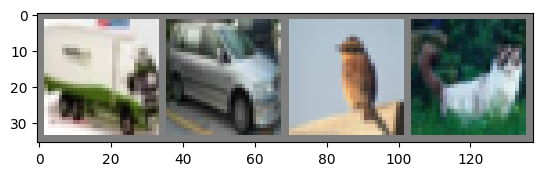

truck automobile bird  cat  


In [ ]:
# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

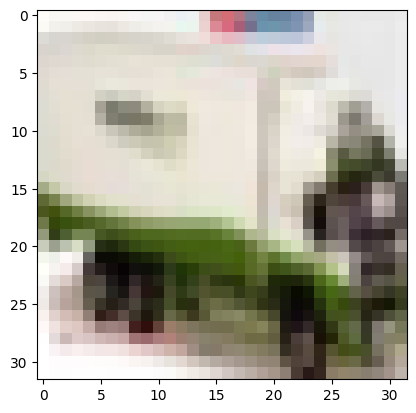

torch.Size([3, 32, 32])
torch.Size([4, 3, 32, 32])


In [ ]:
# Let us take a single image from the dataset, and see how it's represented as a tensor -- this is how the
# computer 'sees' the image.

# Take the first image from above
image0 = images[0]

imshow(image0)

# The resolution is 32x32, and there are 3 RGB channels
print(image0.shape)

# We pass the data into the model in batch sizes of 4, in a tensor form
print(images.shape)

In [ ]:
# Image representation in array/tensor form -- this is how the computer 'sees' each image

print(image0)

tensor([[[ 0.9843,  0.9529,  0.9529,  ...,  0.8118,  0.8118,  0.8353],
         [ 0.9686,  0.8980,  0.8824,  ...,  0.8353,  0.8196,  0.8510],
         [ 0.7333,  0.6863,  0.6941,  ...,  0.8196,  0.8118,  0.8431],
         ...,
         [ 1.0000,  0.9529,  0.9137,  ..., -0.0745,  0.1529,  0.3725],
         [ 1.0000,  0.9922,  1.0000,  ..., -0.1843,  0.1765,  0.4039],
         [ 1.0000,  0.9843,  0.9922,  ...,  0.1451,  0.2706,  0.4980]],

        [[ 0.9765,  0.9451,  0.9451,  ...,  0.8118,  0.8118,  0.8353],
         [ 0.9608,  0.8902,  0.8745,  ...,  0.8353,  0.8196,  0.8510],
         [ 0.7176,  0.6706,  0.6706,  ...,  0.8196,  0.8118,  0.8431],
         ...,
         [ 1.0000,  0.9059,  0.8353,  ..., -0.1137,  0.0902,  0.3176],
         [ 1.0000,  0.9765,  0.9765,  ..., -0.2549,  0.0745,  0.3176],
         [ 1.0000,  0.9843,  0.9843,  ...,  0.0588,  0.1608,  0.4118]],

        [[ 0.9451,  0.9137,  0.9137,  ...,  0.8118,  0.8118,  0.8353],
         [ 0.9216,  0.8510,  0.8353,  ...,  0

Below, we can see that there each equal numbers of datapoints in each class, so there is no need for any kind of stratified sampling, or oversampling, to balance the class sizes. Furthermore, as we know from the source, there are no missing values in this dataset. This makes our task simpler. In a real-world scenario, we are likely to encounter missing data, as well as imbalanced classes. Various methods, such as data imputation, and oversampling to balance the classes, can help to improve the training of a classification model.

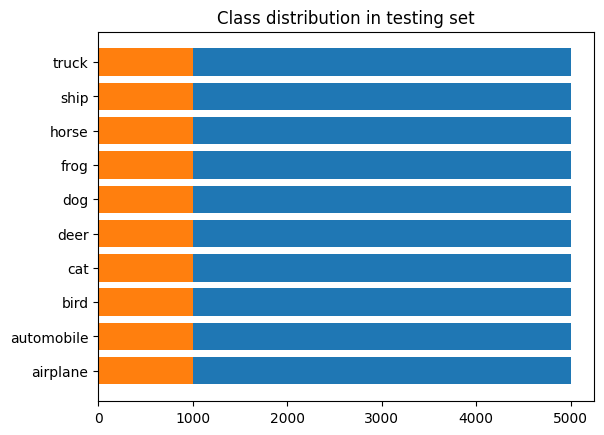

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

class0, counts = np.unique(y_train, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in training set')

class0, counts = np.unique(y_test, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in testing set')
plt.show()

### Creating the CNN

In [ ]:
l1 = 8
l2 = 16

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        # 2D layer, since we have 2D images, with 3 input channels and l1 output
        # channels. This takes the images (which are in RGB space) and transforms
        # them into 6-channel feature maps. We then set a kernel size 5.
        self.conv1 = nn.Conv2d(3, l1, 5)
        # Create a pooling layer – this takes an image and downsizes it with
        # respect to the kernel size and stride. I.e., a kernel size of 2, and a
        # stride of 2. For each 2x2 patch, we take the maximum pixel value for
        # that patch. In essence, we downsize the image to half the resoltion
        # and we take the maximum activation for each of the feature maps at
        # each of the local positions.
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(l1, l2, 5)
        # Fully-connected layers
        self.fc1 = nn.Linear(l2 * 5 * 5, 128)
        # Output of the first fully-connected layer is 128, so this is the input
        # of the next layer.
        self.fc2 = nn.Linear(128, 64)
        # Final output is 10, since there are 10 classes in the CIFAR-10
        # dataset. Therefore, we need a probability for each of the classes;
        # then we can work out how correct (or incorrect) the predictions are.
        # For example, if the input image is a place, then want there to be a
        # low probability for all of the other classes, apart from the deer
        # class, which should have a high probabilty. So we can calculate out
        # loss when we have these 10 output numbers.
        self.fc3 = nn.Linear(64, 10)

    # This declares the forward pass for the network.
    def forward(self, x):
        # We pass through the first convolutional layer, and then through the
        # activation function. Classically, we use an activation function at
        # each of the layers to transform linear transformations into non-linear
        # ones, so we can learn non-linear functions; here, we use the 'ReLU'
        # function.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten all dimensions except batch-size: we want to pass multiple
        # examples through the network at once, and then we can update the
        # weights with respect to the whole batch.
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Final layer
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# Why are there l2*5*5 inputs to the first fully-connected layer? Well, let us
# run through each of the operations step-by-step, and track the resultion of
# the image as we go. Assume that l1 = 6, l2 = 16. Then l2*5*5 = 400.

# We know that a given input image from the CIFAR-10 dataset has a resolution
# of 32x32.

# Operation 1:
# Input 32, kernel size 5, 0 padding, stride of 1
o1 = (32 - 5 + 0) / 1 + 1
# Operation 2: pooling layer -- halves the resolution
o2 = o1 // 2
# Operation 3:
# Input resoltion from step 2, kernel size 5, 0 padding, stride of 1
o3 = (o2 - 5 + 0) / 1 + 1
# Operation 4:
o4 = o3 // 2

# What we see is that after the first convolutional layer, we get a feature map
# which is 28x28. Then we halve the resoltuion to 14x14. Then we run it through
# the second convolutional layer, giving up 10x10. Then we falve the resoltion
# one more time to 5x5.
print(o1, o2, o3, o4)

# This is where we get this 5*5 value. There are 16 channels so we have a
# 16*5*5 image.

28.0 14.0 10.0 5.0


### Training the model

In [ ]:
classifier_model = net
# Defining the loss function
loss_function = nn.CrossEntropyLoss()
# We use stochastic gradient descent as an optimiser
# Learning rate is lr
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NameError: ignored

### Note: takes 5 minutes to run – this is CPU computation.

In [ ]:
epochs = 6

start = time.time()
for epoch in range(epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(train_dataloader, 0):
        # Get the inputs; batch is a list of [images, labels]
        images, labels = batch

        # Zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
        logits = classifier_model(images)
        loss = loss_function(logits, labels)
        # Backwards pass
        loss.backward()
        optimiser.step()

        # Print statistics
        running_loss += loss.item()
        # Keep track of the loss as we proceed through the training loop
        if i % 12000 == 11999:    # print every epoch
            print(f'[{epoch + 1}] loss: {running_loss / 12000:.3f}')
            # Reset running loss each time we print it out
            running_loss = 0.0

end = time.time()
print('Finished Training')
print(f'Runtime: {end - start} seconds')

[1] loss: 1.712
[2] loss: 1.306
[3] loss: 1.162
[4] loss: 1.073
[5] loss: 1.002
[6] loss: 0.953
Finished Training
Runtime: 285.33732318878174 seconds


### Accuracy

In [ ]:
correct = 0
total = 0

# Make sure that we don't calculate gradients whilst we are evaluating the
# performance of the model on the test dataset -- we don't want to change
# the weights.
with torch.no_grad():
    for batch in val_dataloader:
        images, labels = batch
        logits = classifier_model(images)
        # We have a batch size of 4, and 10 classes, therefore we get a 4x10
        # tensor out of our model. So, we take the maximum on the first
        # dimension -- this is the class dimension, since the batch dimension
        # is the 'zeroth' dimension. What we want is the index of the highest
        # value.
        _, predicted = torch.max(logits.data, 1)
        # Now we have a 4x1 tensor
        total += labels.size(0)
        # Gives tensor of whether they are equal or not
        correct += (predicted == labels).sum().item()

print(f'Accuracy over 10,000 validation images: {100 * correct // total}%')


Accuracy over 10,000 validation images: 62%


### What can we glean from this accuracy?

Initially, we might not seem too impressed by the result of about 62%, but we should not be disheartened. Firstly, this value is far batter than chance, which would be a 10% accuracy – i.e., we choose at random which class a given image belongs to, and there are 10 choices. So, the network has clearly learnt something. The simple PyTorch tutorial that the code is inspired by had only an accuracy of 55%, so this is a clear improvement.

Next, consider the EMNIST dataset: a set of hand-drawn digits with a resoltion of 28x28. A more detailed explanation of the contents and conversion process of the dataset are given in a paper by Cohen, et al $[3]$.

It is not difficult for very simplistic models to perform very well in classification on this dataset -- models easily reach over 99% accurary. However, reaching an accuracy of over 90% on the CIFAR-10 dataset is very challenging – even for humans! Many state of the art models are tested on the CIFAR-10 dataset.

Now, let us now look at the performance of the model on each class inividually.

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 68.8 %
Accuracy for class: automobile is 73.3 %
Accuracy for class: bird  is 45.5 %
Accuracy for class: cat   is 36.6 %
Accuracy for class: deer  is 74.4 %
Accuracy for class: dog   is 52.5 %
Accuracy for class: frog  is 62.5 %
Accuracy for class: horse is 61.8 %
Accuracy for class: ship  is 79.0 %
Accuracy for class: truck is 70.3 %


We can see that the model's performance varied significantly on the different classes.

## <ins>Improvements</ins>

There are many ways to improve the model. Let us first consider how we might speed up the training process.

### <ins>Parallelism via GPU</ins>

### Understanding NVIDIA CUDA: The Basics of GPU Parallel Computing

GPU Parallel computing is used uqiquitously in machine learning; specifically, the fields of 'image recognition algorithms, text analysis, and predictive modeling.' [$[9]$](https://www.turing.com/kb/understanding-nvidia-cuda#what-is-cuda?).

Machine learning ML is used in a variety of fields. It's used in image recognition algorithms, text analysis, and predictive modeling.

Video: [How do GPUs speed up Neural Network training?](https://www.youtube.com/watch?v=EKD1kEMNeeU)

Compute Unified Device Architecture (CUDA) is a framework created by NVIDIA to perform GPU-accelerated operations. By utilising CUDA GPUs, one is able to perform data processing faster than with the standard methods used with CPUs. This is because CUDA employs parallel processes to achieve greater efficiency and speeds when processing data.

<strong>Why is GPU faster than CPU in a CNN?</strong>
There are several reasons why GPUs tend to be faster, and perform better, than CPUs in convolutional neural networks.

<strong>Parallel processing:</strong>
GPUs use parallel processing to handing many tasks all at once. For CNNs, a great many matrix operations are performed by the models, such as matrix multiplication and convolution. GPUs are able to parallelise many of these operations at the same time — this can vastly reduce the training time of neural networks, such as image classifiers. Furthermore, due to the architecture of GPUs, they allow for the efficient simultaneous computation of entire layers within a CNN.

<strong>GPUs have more cores:</strong>
GPUs usually contain a much larger number of cores than CPUS. Namely, CPUs often have only a few cores, whereas GPUs often contain hundreds, or thousands, of smaller cores. Therefore, for tasks involving a larger number of simple repetitive operations, GPUs perform much better.

<strong>Architecture:</strong>
Involved in neural networks are many matrix and vector operations. The specific design of the GPU architecture is optimised for handling vast amounts of mathematical operations in the processing and rendering of graphics. This use precisely aligns with the computational and mathematical requirements of neural networks.

<strong>Memory:</strong>
The memory bandwidth — i.e., the rate that data is able to be read or stored into a semiconductor memory by a processor — is much higher in GPUs than it is in CPUs. Involved in CNNs are great numbers of data transfers between layers, and this requires a lot of memory bandwidth — something GPUs are well equipped for.

<strong>CUDA:</strong>
NVIDIA’s ‘Compute Unified Device Architecture’ (CUDA) platform performs highly optimised parallel computing. Specifically, Tensor Cores in NVIDIA GPUs are used to greatly speed up processes in deep learning, such as matrix multiplications.

To summarise, GPUs utilise their parallel framework, hardware, and software to handle data on large scales, performing repetitive tasks that are highly parallelisable. For these reasons, they are often the optimal choice for use in deep learning.

We shall use tools in PyTorch for this GPU for this GPU-acceleration [$[8]$]((https://domino.ai/blog/gpu-accelerated-convolutional-neural-networks-with-pytorch?fbclid=IwAR0vqjv6PFzwb2M8ZO7wjo11pg4_5UCfEla6N9n8PwSwZtHzbkKPPQm_wSg)).


### Comparisons of GPU and CPU runtimes for matrix operations on different size matrices

The GPU we used for this analyis is an NVIDIA Tesla V100 with 5120 cuda cores run on Google Colab, and the CPU is the 64-bit Apple M1 processor (SoC) with eight cores (4 performance cores, 4 efficiency cores). The inspiration for the following code can be [here](https://datascience.stackexchange.com/questions/41956/how-to-make-my-neural-netwok-run-on-gpu-instead-of-cpu).

In [ ]:
import numpy as np
import tensorflow as tf
from datetime import datetime

# View devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:


tf.compat.v1.disable_eager_execution()
print(tf.__version__)

# Choose which device you want to test on: either 'cpu' or 'gpu'
devices = ['cpu', 'gpu']

# Choose size of the matrix to be used.
# Make it bigger to see bigger benefits of parallel computation
shapes = [(100, 100), (1000, 1000), (2000, 2000), (4000, 4000), (8000, 8000),
          (12000, 12000), (16000, 16000), (20000, 20000), (30000, 30000)
          ]


def compute_operations(device, shape):
    """Run a simple set of operations on a matrix of given shape on given device

    Parameters
    ----------
    device : the type of device to use, either 'cpu' or 'gpu'
    shape : a tuple for the shape of a 2d tensor, e.g. (10, 10)

    Returns
    -------
    out : results of the operations as the time taken
    """

    # Define operations to be computed on selected device
    with tf.device(device):
        random_matrix = tf.random.uniform(shape=shape, minval=0, maxval=1)
        dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
        sum_operation = tf.reduce_sum(dot_operation)

    # Time the actual runtime of the operations
    start_time = datetime.now()
    with tf.compat.v1.Session(
        config=tf.compat.v1.ConfigProto(log_device_placement=False)) as session:
        result = session.run(sum_operation)
    elapsed_time = datetime.now() - start_time

    return result, elapsed_time

if __name__ == '__main__':

    times = []
    # Run the computations and print summary of each run
    for device in devices:
        print("--" * 20)
        for shape in shapes:
            _, time_taken = compute_operations(device, shape)
            time_taken = time_taken.seconds + time_taken.microseconds/1e6
            times.append(time_taken)

            # Print the result and also the time taken on the selected device
            print("Computation on shape:", shape, "using device:", device,
                  "took: {:.3f}".format(time_taken), "seconds")
    print("--" * 20)

    cpu_times = times[:len(times)//2]
    gpu_times = times[len(times)//2:]
    cpu_times.pop(0)
    gpu_times.pop(0)
    shapes.pop(0)

2.15.0
----------------------------------------
Computation on shape: (100, 100) using device: cpu took: 0.725 seconds
Computation on shape: (1000, 1000) using device: cpu took: 0.020 seconds
Computation on shape: (2000, 2000) using device: cpu took: 0.077 seconds
Computation on shape: (4000, 4000) using device: cpu took: 0.533 seconds
Computation on shape: (8000, 8000) using device: cpu took: 4.326 seconds
----------------------------------------
Computation on shape: (100, 100) using device: gpu took: 0.149 seconds
Computation on shape: (1000, 1000) using device: gpu took: 0.015 seconds
Computation on shape: (2000, 2000) using device: gpu took: 0.011 seconds
Computation on shape: (4000, 4000) using device: gpu took: 0.019 seconds
Computation on shape: (8000, 8000) using device: gpu took: 0.103 seconds
----------------------------------------


### Plot of computational time for $nxn$ matrix operation, GPU vs CPU

From the following plot, it is clear to see that as the dimension of the matrix increases, the runtime increases at a much faster rate with computation done under CPU than under GPU. This experimental result agrees with the analysis presented in the previous section on why GPUs perfrom these operations much quicker than CPUs. Using GPUs to improve training speeds will be very useful as we adapt and improve our models to more complicated, and therefore more computationally intensive, versions. We shall increase the batch size, and the size of the convolutional layers, as well as perform more operations on tensors: this will require using GPU computation, since computation via CPU on these operations, at larger scales, will take far too long.

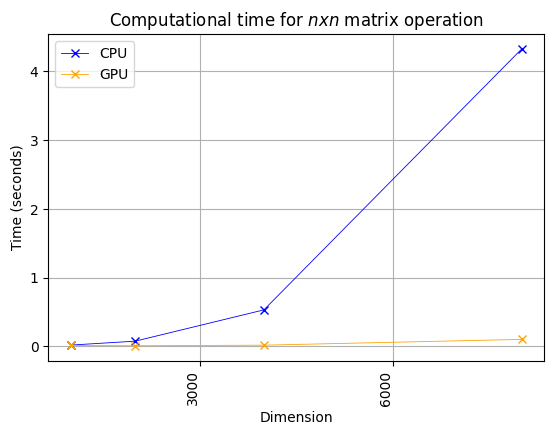

In [ ]:
dimensions = [x[0] for x in shapes]

fig, ax = plt.subplots() # using matplotlib's Object Oriented API
ax.set_title('Computational time for $nxn$ matrix operation')
ax.set_xlabel('Dimension')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(np.arange(0, 30000 + 1, 3000))
fig.autofmt_xdate(rotation=90)
ax.plot(dimensions, cpu_times, color='blue', marker='x', linewidth=0.6, label='CPU')
ax.plot(dimensions, gpu_times, color='orange', marker='x', linewidth=0.6, label='GPU')
plt.legend(loc="upper left")
plt.grid()

plt.show()

#### Let us inspect the GPU computation times at a closer scale. The computation time is so much faster than CPU that it is not easy to discern the pattern of the results on the dual graph.

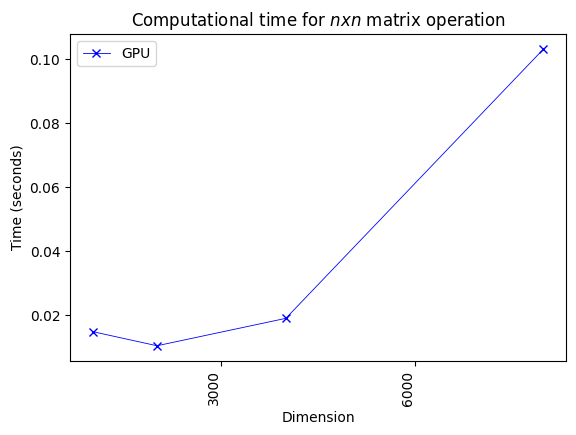

In [ ]:
fig, ax = plt.subplots() # using matplotlib's Object Oriented API

ax.set_title('Computational time for $nxn$ matrix operation')
ax.set_xlabel('Dimension')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(np.arange(0, 30000 + 1, 3000))
fig.autofmt_xdate(rotation=90)
ax.plot(dimensions, gpu_times, color='blue', marker='x', linewidth=0.6, label='GPU')
plt.legend(loc="upper left")

plt.show()

### CNN operations

In a CNN, the convolution process of sliding a kernel is a element-wise multiplication process, and then it sums the elements together. These are computationally intensive tasks, and the CPU finds it much harder to compute when more and more layers are added. Similarly, when the layers are widened, the CPU will also strugging due to its architecture. For the reasons stated above, GPUs are better suited to these computational tasks. We should expect an analogous speedup, from the results we have just seen, of GPU computation over CPU computation when increasing the complexity of a CNN.

## Analysis: CNN on GPU

Below, we increase the batch size, and increase the number of epochs. This is a computation we can now do much faster on GPU.





In [68]:
# Set larger batch size
batch_size = 128
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
# Choose compute device type
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Uncomment to run on cpu
#device = 'cpu'

In [70]:
l1 = 64
l2 = 128

# Redefine to allow sending computation to GPU
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, l1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(l1, l2, 5)
        self.fc1 = nn.Linear(l2 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    # This declares the forward pass for the network.
    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [71]:
# Send to device
net.to(device)

# Check if the params are on GPU. Should output True if the model is on the GPU
print(next(net.parameters()).is_cuda)

True


In [72]:
classifier_model = net
# Defining the loss function
loss_function = nn.CrossEntropyLoss()
# We use stochastic gradient descent as an optimiser
# Learning rate is lr
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### This takes 5 minutes to run, but the accuracy is now over 70%

In [ ]:
epochs = 40

start = time.time()
mini_batch = len(train_dataloader) - 1
losses = []
for epoch in range(epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in enumerate(train_dataloader, 0):
        # Get the inputs; batch is a list of [images, labels]
        images, labels = batch
        # Send these tensors to GPU for computation
        images, labels = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimiser.zero_grad()

        # forward + backward + optimize
        logits = classifier_model(images)
        loss = loss_function(logits, labels)
        # Backwards pass
        loss.backward()
        optimiser.step()

        # Print statistics
        running_loss += loss.item()
        # Keep track of the loss as we proceed through the training loop
        if i % mini_batch == (mini_batch-1):    # print every epoch
            loss = running_loss/mini_batch
            print(f'[Epoch: {epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')
            losses.append(loss)
            # Reset running loss each time we print it out
            running_loss = 0.0

end = time.time()
print('Finished Training')
print(f'Runtime: {end - start} seconds')

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for batch in val_dataloader:
        images, labels = batch
        images, labels = batch[0].to(device), batch[1].to(device)

        logits = net(images)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy over 10000 validation images: {100 * correct / total}%')

### Interpretation:

We can see that we have been able to increase the accurary of our model by training with more epochs, while also increasing the batch size. We have kept the runtime around the same, using GPU computaton speed boost.

Let us see how the accuracy changes as we increase the number of epochs.


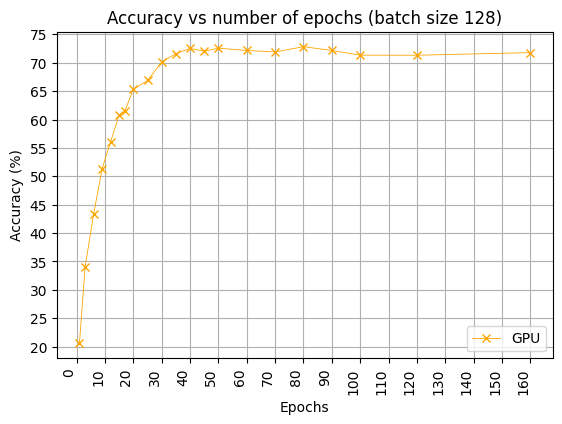

In [ ]:
# Results: (epochs, runtime, accuracy)
epoch_computations = [(1, 7.408554792, 20.58), (3, 22.32866406, 34.06),
                      (6, 44.73545718, 43.34), (9, 67.79624248, 51.34),
                      (12, 89.88221908, 56.1), (15, 113.297296, 60.78),
                      (17, 127.0894275, 61.5), (20, 148.2551584, 65.31),
                      (25, 184.7168143, 66.88), (30, 222.9016218, 70.09),
                      (35, 278.0812137, 71.6), (40, 316.836256, 72.52),
                      (45, 353.6044488, 72.03), (50, 401.4707859, 72.56),
                      (60, 448.4164722, 72.16), (70, 503.9833045, 71.89),
                      (80, 575.6888978, 72.83), (90, 647.5170252, 72.16),
                      (100, 718.2058516, 71.33), (120, 904.9342792, 71.32),
                      (160, 1189.518613, 71.78)]

x0 = [x[0] for x in epoch_computations]
y_vals = [x[2] for x in epoch_computations]

fig, ax = plt.subplots() # using matplotlib's Object Oriented API

ax.set_title('Accuracy vs number of epochs (batch size 128)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(np.arange(0, 160 + 1, 10))
ax.set_yticks(np.arange(0, 81, 5))
fig.autofmt_xdate(rotation=90)
ax.plot(x0, y_vals, color='orange', marker='x', linewidth=0.6, label='GPU')
plt.legend(loc="lower right")
plt.grid()

plt.show()



This model reaches an accuracy of around 72-73 percent. Inspecting the graph above, it is not likely that the performance will reach a higher accuracy. This indicates that we need to use a more powerful model that better learns the relationship between the input image and the given classes. Luckily, there are tools and methods of doing just this. We can use tools such as batch normalisation, adding more convolutional layers, or increasing the number of channels in the concoltional layers. In ResNet, at the end, we use a new concept of 'residual blocks' for better training, as well as an optimiser than updates te learning rate during training.

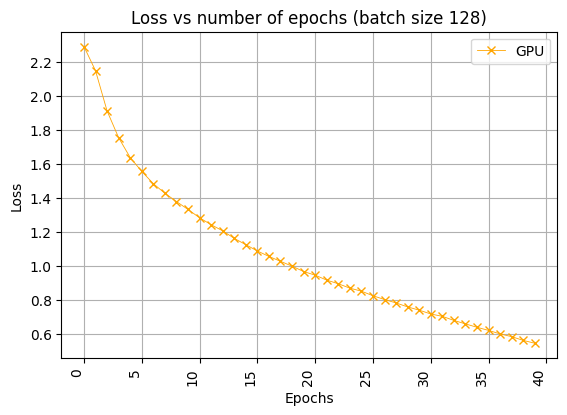

In [77]:
# Results from computation of 40 epochs

losses = [2.291115410797431, 2.148948510284619, 1.9121665567388315,
          1.7543728436960284, 1.637560645942493, 1.5560105423183392,
          1.4838974399639822, 1.427204738187668, 1.3787011466062893,
          1.331928366895222, 1.283140567257581, 1.2420185533021113,
          1.2061319261255776, 1.1617660466057564, 1.1244802942971135,
          1.0874351320974052, 1.0554725700022314, 1.0265474505436696,
          0.9982285975190379, 0.966488349468202, 0.9450786877471162,
          0.9159211824312234, 0.894616000945001, 0.8687216737081328,
          0.8509254390016541, 0.823837133472228, 0.8016081813656156,
          0.7815181946815433, 0.7581117176033957, 0.7391059174562049,
          0.7165729947712111, 0.7026683135563151, 0.6786948660450518,
          0.6581839047886832, 0.6382976758205677, 0.6198027787915886,
          0.5993096672970316, 0.5829567461824783, 0.5610159378679817,
          0.5442586294220536]

fig, ax = plt.subplots()

ax.set_title('Loss vs number of epochs (batch size 128)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xticks(np.arange(0, 40 + 1, 5))
ax.set_yticks(np.arange(0, 3, 0.2))
fig.autofmt_xdate(rotation=90)
ax.plot(range(len(losses)), losses, color='orange', marker='x', linewidth=0.6,
        label='GPU')
plt.legend(loc="upper right")
plt.grid()

plt.show()

Note that the training loss continues to decreases steadily as the number of epochs increase. But, as we can see from the previous graph, the accuracy plateaus and doesn't decrease beyond a certain point.

This is because of overfitting. The model, in an attempt to continue minimising the loss, will try to memorize patterns specific to the dataset too much. This causes it to be unable to perform better on unseen data, and often the performance of the model, in terms of the accuracy, will start to decrease at this point as more noise is added in the model.

Using techniches such as batch normalisation, dropout, and residual layers will be explored later; we shall see that this leads to a more accurate model.

## Comparison of GPU vs CPU computions

Below, we see that the training time on different batch sizes follows a similar pattern for both GPU and CPU computations; however, GPU is consistently much faster. We keep the number of epochs then same, for comparison.

Then we show how the accuracy varies as a function of the number of epochs used to train the network.

In [ ]:
# (batch size, runtime (seconds), accuracy)

gpu_computes = [(4, 433.3880789, 73.8),
                (8, 216.0823815, 73.39),
                (16, 114.7200339, 73.57),
                (32, 89.74474382, 71.45),
                (64, 79.80019307, 63.16),
                (128, 72.4001863, 51.89),
                (256, 68.97899532, 41.75),
                (512, 66.80634308, 31.77),
                (1024, 67.52044535, 22.18)]

cpu_computes = [(4, 1081.162732, 72.04),
                (8, 811.0543149, 73.05),
                (16, 654.4295506, 73.77),
                (32, 598.5905275, 71.34),
                (64, 546.3165207, 64.15),
                (128, 530.3795588, 52.67),
                (256, 566.4555404, 43.82),
                (512, 636.495065, 32.08),
                (1024, 691.1057892, 20.7)]

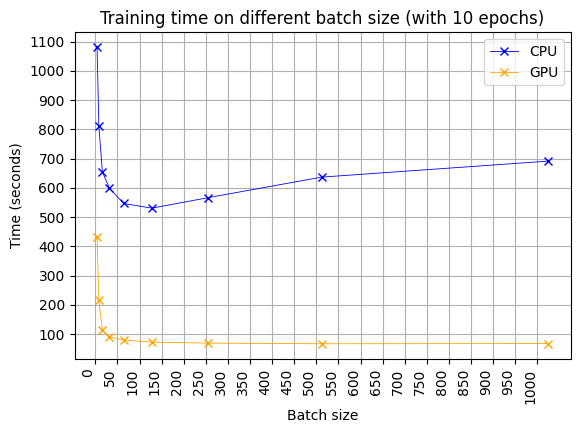

In [ ]:
x1 = [x[0] for x in gpu_computes]
gpu_times = [x[1] for x in gpu_computes]
x2 = [x[0] for x in cpu_computes]
cpu_times = [x[1] for x in cpu_computes]

fig, ax = plt.subplots() # using matplotlib's Object Oriented API

ax.set_title('Training time on different batch size (with 10 epochs)')
ax.set_xlabel('Batch size')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(np.arange(0, 1000 + 1, 50))
ax.set_yticks(np.arange(0, 1100 + 1, 100))
fig.autofmt_xdate(rotation=90)
ax.plot(x2, cpu_times, color='blue', marker='x', linewidth=0.6, label='CPU')
ax.plot(x1, gpu_times, color='orange', marker='x', linewidth=0.6, label='GPU')
plt.legend(loc="upper right")
plt.grid()
plt.show()

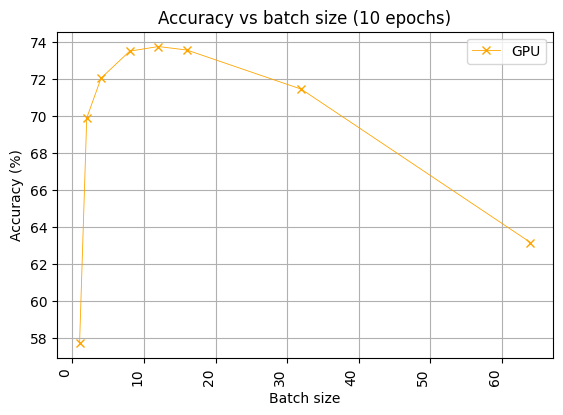

In [ ]:
# More computes for lower batch sizes
gpu_computes1 = [(1, 1650.808966, 57.71),
                 (2, 795.7941215, 69.89),
                 (4, 418.9475262, 72.05),
                 (8, 213.3426504, 73.51),
                 (12, 146.6565442, 73.76),
                 (16, 114.7200339, 73.57),
                 (32, 89.74474382, 71.45),
                 (64, 79.80019307, 63.16)]

x3 = [x[0] for x in gpu_computes1]
gpu_acc = [x[2] for x in gpu_computes1]

fig, ax = plt.subplots() # using matplotlib's Object Oriented API

ax.set_title('Accuracy vs batch size (10 epochs)')
ax.set_xlabel('Batch size')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(np.arange(0, 70 + 1, 10))
ax.set_yticks(np.arange(54, 81, 2))
fig.autofmt_xdate(rotation=90)
ax.plot(x3, gpu_acc, color='orange', marker='x', linewidth=0.6, label='GPU')
plt.legend(loc="upper right")
plt.grid()

plt.show()

The accuracy is initially very low, as the batch size is tiny. The accuracy then reaches a peak, and then diminishes as the batch size increases.

With the batch size, there is a certain trade-off between the accuracy of the model, and the speed. As we saw from the graph, a small batch size has a very large computation time, while larger batch sizes  greatly reduce the training time. So we can see that we need a balance between the training time of the mode, and accuracy.  This is also explained [here](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch).


Inspecting these graphs, we can see that a batch size of around 12, with 10 epochs, leads to the highest accuracy. Furthermore, on GPU, this does not have an enormous runtime; this shows the benefit parallel computation architecture of the GPU.

Note that larger batch sizes are less susceptible to random fluctuations within the trainset. This is because the training, in each epoch, is done over more data which smooths out these abnormalities, so to speak. However, a larger batch size may cause the model to converge slower; this is another of the many trade-offs we encounter in machine learning. There is no ideal batch size, and there needs to be an analysis to decide on a case-by-case basis which is the best for each model.

## <ins>Batch normalisation (used in ResNet)</ins> $[7]$

We shall explore the ways in which batch normalisation can be used to improve the performance of neural networks, as well as other advantages its use offers.

One of the most integral and ubiquitous problems in the field of data science, when training classifiers, is that of over-fitting. The issue can be typified by the following: consider a scenario where a model performs very well during training — so well that we become very optimistic about its further employment on unseen data; however, when applied to unseen test data, the model fails to deliver the expected strong performance we had hoped for; here we come across the problem: overfitting. The model has been trained too well on the given training data, and therefore it has not the ability to adapt and deliver well on new data. An attempt to solve this problem is a method of regularisation: this technique aids the speed of convergence of a model. Various such techniques exist, such as batch normalisation, as well as weight initialisation techniques.

### So, [what is batch normalisation](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/#:~:text=By%20reducing%20internal%20covariate%20shift%2C%20batch%20normalization%20allows%20for%20higher,more%20efficient%20neural%20network%20training.)?

Firstly, let us clearly define what we mean by our use of the term ‘normalisation.’ Normalisation is a pre-processing technique that we employ onto data in order to scale it, without distorting its shape.

In deep learning models, it is most often beneficial to scale the data in this manner. This way, we attempt to ensure that our model is able to successfully generalise (onto unseen data).

Batch normalisation aims to make faster the performance of neural networks, as well as increasing their stability by adding more layers into the network. These new layers perform standardisation and normalisation operations on the inputted data that ‘arrives’ from the previous layer.

### Now, why should we use batches?

Typically, the process of training a neural network uses data that are split into a collected set that is termed a ‘batch.’ Therefore, the normalisation operations are performed on these data batches, and not on the entire dataset at once. This process has the advantage of speeding up the training process by normalising the activation layer.

Note that if the features vary widely, such as those not on the same scale (e.g. age and miles driven), larger datapoints can cause instability in the network, since the realtively large inputs can cascade down through the layers in the network, potentially resulting in highly imbalanced gradients. Furthermore, non-normalised data decrease training speeds.

Note that, through the process of stochastic gradient descent, during training, some weights sometimes become much larger than the others. This causes imbalance and instability in the network. Batch normalisation at each stage the batches enter the next layer, or simply just the layers one chooses, aims to solve this issue. This very process is trainable, and can therefore be optimised. The parameters of the normalisation, such as the mean, standard deviation, and weight ceofficients can all be trained.


Training Convolutional Neural Network (CNN) is a computationally intensive task whose parallelization has become critical in order to complete the training in an acceptable time. However, there are two obstacles to developing a scalable parallel CNN in a distributed-memory computing environment. One is the high degree of data dependency exhibited in the model parameters across every two adjacent minibatches and the other is the large amount of data to be transferred across the communication channel. In this paper, we present a parallelization strategy that maximizes the overlap of inter-process communication with the computation. The overlapping is achieved by using a thread per compute node to initiate communication after the gradients are available. The output data of backpropagation stage is generated at each model layer, and the communication for the data can run concurrently with the computation of other layers. To study the effectiveness of the overlapping and its impact on the scalability, we evaluated various model architectures and hyperparameter settings. When training VGG-A model using ImageNet data sets, we achieve speedups of 62.97× and 77.97× on 128 compute nodes using mini-batch sizes of 256 and 512, respectively.

## <ins>ResNet</ins>

ResNet, or residual network, is a term for a form of neural network that uses in its architecture the notion of 'residual blocks.' Inputs into these blocks can 'skip' layers and be added to the output of a layer further in the network. This is done through a process of 'shortcuts.'

### Motivation: what do we mean by the 'residual?'

Suppose we have the following problem: we wish to create a function (i.e. a neural network) that takes as an input a low-resolution image and outptus a higher resolution version of the image. Clearly, an input image has a limited amount of information, and we cannot magically make clearer what we do not know is there; however, with machine learning and AI, we can create a model that accomplishes this task. Such a model can be trained on thousands of images to learn how to 'predict' what information is missing from the original image – we call this missing information the 'residual'; the original low-resolution input image can then be augmented with this learnt information to form a high-resoltuion output.

So, given that we have low-resolution input image data at the time of training, we can create a network to learn only the part of the image that we care about – the residual. Framing the problem in this way makes the network's job much easier, since it doesn't need to retain the entire input signal. This was the same intuition that inspired the authors of the 2015 paper 'Deep Residual Learning for Image Recognition.' $[11]$ This paper is considered seminal in the field of deep learning. It is rare to find a model architecture in deep learning that does not utilise the contributions from this paper in some fashion.

Now, we often want to create a model with inputs and outputs that do not share the same dimensions. For example, in image classification, where you have an input image and map it to a single class label. How do we meaningfully add inputs and outputs in such a scenario? We must consider how the input signal is propagated throughout the network. What we don't want to do is lose track of an input signal after several layers in the network. Now, if we add residual connections all the way along the network, we can boost the input signal all the way along the network. This allows us to sum inputs and outputs, since the dimensionality is adjusted on the go. The nework is then a series of 'residual blocks,' rather than independent layers. Thus, the network has the option of not fully-utilising all the blocks, since it is easy for each block to output the identity function, and take no penalty in relation to the loss function; this allows us to train extemely deep networks.

### A closer look at the architecture: the residual block

<img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164_2_mD02h5A.png" alt="residual block" style="width:350px;"/>

In the above diagram an input (or identity), $x$, arrives into the weight layer. This layer includes a convolutional layer, batch normalisation, and then an activation layer using the ReLU function. Then we pass through another convolutional layer and then batch normalisaion These layers aim to learn the residual function, $F(x)$, with respect to the input signal. The identity is added to this function, yielding $
F(x) + x$, and then ReLU is applied. More formally, a desired underlying mapping $H(x)$ can be expressed as $F(x) := F(x) - x$. We then recast the original mapping into $F(x) + x$, where $F(x)$ acts as a residual. This defines the residual block.

#### Below is a sample of code that uses pytorch to implement the forward pass of a residual block.



In [ ]:
def fwd(self, x): # x is a tensor
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### The issue of dimensionality

In the original paper, the authors proposed a method of downsampling throughout the network, where convolutional layers ocasionally have a stride of two. This produces features with half the heigh, half the width, and double the number of convolutional filters, which in-turn doubles the number of channels in the output features. A problem here arises with dimension matching, since the input that is sent through the residual connection does not have the same dimensions as the features coning through the network.

#### The authors' proposed a solution:

The solution is to match the number of channels by passing over the input features with a 1x1 convolution. 'A projection shortcut is used to match dimensions (done by 1x1 convolutions).' This, of course, adds extra parameters. A stride of two is used: 'when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2.' This means that the output feature maps have half the width, half the height, and double the channels. Hence, they exactly match the current input features in the network. The authors found this approach to be the best.

## <ins>Implementing ResNet</ins>

This code is taken from/inspired by the following link.

In [96]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}

    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [97]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = [] #store model accuracy and loss for each epoch
    training_start_time=time.time()
    optimizer = opt_func
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    return history

In [98]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [121]:
def plot_loss_accuracy(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(val_losses,'-x', label='val loss', color='blue')
    axes[0].plot(train_losses,'-x', label='train loss', color='orange')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_title('Loss vs. No. of epochs')
    axes[0].set_xticks(np.arange(0, 31, 2))
    axes[0].legend()


    axes[1].plot(accuracies,'-x')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].set_title('Accuracy vs. No. of epochs')
    axes[1].set_xticks(np.arange(0, 31, 2))
    plt.show()

In [100]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [101]:
# Create smaller validation set within training set
torch.manual_seed(42)
val_size=5000 #10% of training data
train_size=len(train_data)-val_size
train_data,valset=torch.utils.data.random_split(train_data,[train_size,val_size])
print(len(train_data), len(valset))

45000 5000


In [102]:
batch_size = 128
train_data=torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,
                                       pin_memory=True)
valset=torch.utils.data.DataLoader(valset,batch_size, shuffle=False,
                                     pin_memory=True)
test_data=torch.utils.data.DataLoader(test_data, batch_size, shuffle=False,
                                      pin_memory=True)

In [103]:
train_data = DeviceDataLoader(train_data, device)
valset = DeviceDataLoader(valset, device)
test_data = DeviceDataLoader(test_data, device)

In [104]:
class ResNet(ImageClassificationBase):

    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),#2D Batch Normalization since our inputs are 4D.
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(128*4*4,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10))

    def forward(self,x):
        return self.network(x)

In [105]:
model_ResNet = to_device(ResNet(), device)

In [106]:
num_epochs=30
lr=0.001
opt_func=torch.optim.Adam(model_ResNet.parameters(), lr)


## Code takes a few minutes

In [107]:
start = time.time()
history_ResNet = fit(num_epochs, lr, model_ResNet, train_data, valset, opt_func)
end = time.time()
print('Finished Training')
print(f'Runtime: {end - start} seconds')

Epoch [0], train_loss: 1.4119, val_loss: 1.1738, val_acc: 0.5957
Epoch [1], train_loss: 1.0340, val_loss: 0.8504, val_acc: 0.6949
Epoch [2], train_loss: 0.8668, val_loss: 0.7366, val_acc: 0.7314
Epoch [3], train_loss: 0.7753, val_loss: 0.8529, val_acc: 0.7064
Epoch [4], train_loss: 0.7052, val_loss: 0.7047, val_acc: 0.7521
Epoch [5], train_loss: 0.6568, val_loss: 0.6761, val_acc: 0.7615
Epoch [6], train_loss: 0.6048, val_loss: 0.6313, val_acc: 0.7812
Epoch [7], train_loss: 0.5686, val_loss: 0.5864, val_acc: 0.7961
Epoch [8], train_loss: 0.5335, val_loss: 0.5984, val_acc: 0.7895
Epoch [9], train_loss: 0.5014, val_loss: 0.6183, val_acc: 0.7887
Epoch [10], train_loss: 0.4719, val_loss: 0.5666, val_acc: 0.8045
Epoch [11], train_loss: 0.4439, val_loss: 0.5824, val_acc: 0.8047
Epoch [12], train_loss: 0.4209, val_loss: 0.5308, val_acc: 0.8293
Epoch [13], train_loss: 0.3961, val_loss: 0.5653, val_acc: 0.8146
Epoch [14], train_loss: 0.3768, val_loss: 0.5509, val_acc: 0.8232
Epoch [15], train_lo

In [123]:
test(model_ResNet, test_data)

{'test_loss': 0.6195818185806274, 'test_acc': 0.8262460231781006}

### Success!

The accuracy of the ResNet model is much higher than before. Note that many more improvements can be made, and state-of-the-art models are now pushing towards 100% test accuracy. An [example](https://myrtle.ai/learn/how-to-train-your-resnet/) blog achieves a 94% accuracy threshhold on a single V100 GPU - the same used here.

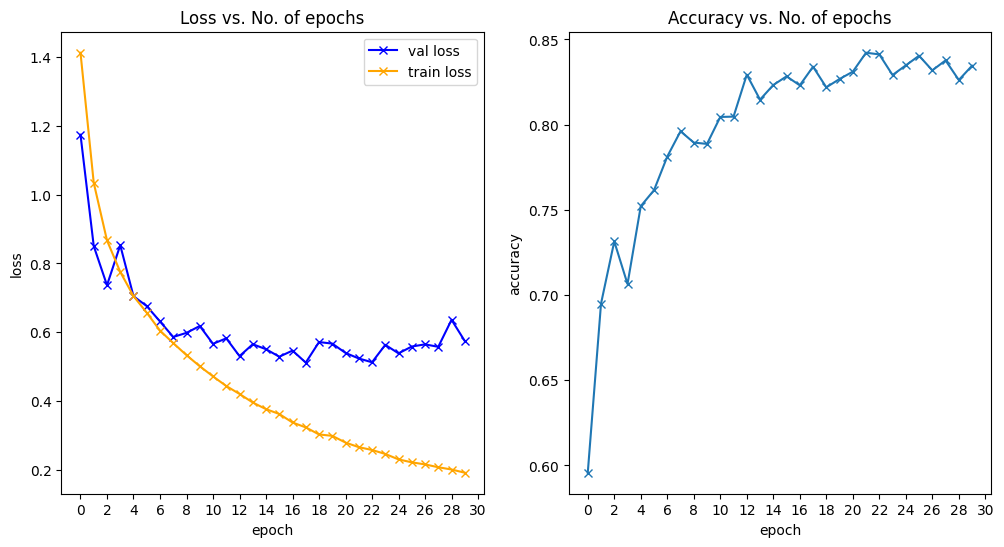

In [122]:
plot_loss_accuracy(history_ResNet)

We note that in the graph on the left, the validation loss (note that the loss is a measure of error) stops decreasing after a certain number of epochs, while the training loss continues to decrease. We discussed this earlier, and this is due to overfitting of the model. Overfitting is one of the main problems we must overcome in datascience, and machine learning. If we were to train using even more epochs, we would find that the validation loss will incrase. This will, in-turn, cause the test accuracy of the model to fall. This is because it fails to adapt to new unseen data when it is overfitted to the training data.

This empircal result mirrors this theoretical graph, found [here](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch).

<img src="https://i.stack.imgur.com/1QU0m.png" alt="graph" style="width:350px;"/>





In [110]:
# Storing the results of ResNet run with 30 epochs (training of 451 seconds)

results_ResNet = [{'val_loss': 1.1738336086273193,
  'val_acc': 0.595703125,
  'train_loss': 1.4118685722351074},
 {'val_loss': 0.8503761291503906,
  'val_acc': 0.6949218511581421,
  'train_loss': 1.0339841842651367},
 {'val_loss': 0.7366348505020142,
  'val_acc': 0.7314453125,
  'train_loss': 0.8667844533920288},
 {'val_loss': 0.8528968095779419,
  'val_acc': 0.7064453363418579,
  'train_loss': 0.7753389477729797},
 {'val_loss': 0.7047030925750732,
  'val_acc': 0.752148449420929,
  'train_loss': 0.7052079439163208},
 {'val_loss': 0.6760860681533813,
  'val_acc': 0.761523425579071,
  'train_loss': 0.6568374633789062},
 {'val_loss': 0.6313431859016418,
  'val_acc': 0.78125,
  'train_loss': 0.6048000454902649},
 {'val_loss': 0.5864030122756958,
  'val_acc': 0.796093761920929,
  'train_loss': 0.568634033203125},
 {'val_loss': 0.5983705520629883,
  'val_acc': 0.7894531488418579,
  'train_loss': 0.5335195660591125},
 {'val_loss': 0.6182528734207153,
  'val_acc': 0.7886718511581421,
  'train_loss': 0.5014123916625977},
 {'val_loss': 0.5665678381919861,
  'val_acc': 0.804492175579071,
  'train_loss': 0.4719301760196686},
 {'val_loss': 0.5824182033538818,
  'val_acc': 0.8046875,
  'train_loss': 0.44393500685691833},
 {'val_loss': 0.5307778716087341,
  'val_acc': 0.829296886920929,
  'train_loss': 0.42094457149505615},
 {'val_loss': 0.5653226971626282,
  'val_acc': 0.814648449420929,
  'train_loss': 0.39610767364501953},
 {'val_loss': 0.5508533716201782,
  'val_acc': 0.8232421875,
  'train_loss': 0.37676379084587097},
 {'val_loss': 0.5291057825088501,
  'val_acc': 0.828320324420929,
  'train_loss': 0.3627541959285736},
 {'val_loss': 0.5468037724494934,
  'val_acc': 0.823046863079071,
  'train_loss': 0.33803510665893555},
 {'val_loss': 0.5119414925575256,
  'val_acc': 0.833984375,
  'train_loss': 0.3238164782524109},
 {'val_loss': 0.5716387033462524,
  'val_acc': 0.8218749761581421,
  'train_loss': 0.3033255636692047},
 {'val_loss': 0.5671338438987732,
  'val_acc': 0.8267577886581421,
  'train_loss': 0.29927435517311096},
 {'val_loss': 0.5400354266166687,
  'val_acc': 0.8310546875,
  'train_loss': 0.27967146039009094},
 {'val_loss': 0.5239763259887695,
  'val_acc': 0.8421875238418579,
  'train_loss': 0.26642417907714844},
 {'val_loss': 0.5128991007804871,
  'val_acc': 0.8412109613418579,
  'train_loss': 0.2581913471221924},
 {'val_loss': 0.5635442137718201,
  'val_acc': 0.8291015625,
  'train_loss': 0.24669302999973297},
 {'val_loss': 0.5388285517692566,
  'val_acc': 0.834765613079071,
  'train_loss': 0.23084819316864014},
 {'val_loss': 0.5586759448051453,
  'val_acc': 0.8404296636581421,
  'train_loss': 0.22232389450073242},
 {'val_loss': 0.5649061799049377,
  'val_acc': 0.831835925579071,
  'train_loss': 0.21633465588092804},
 {'val_loss': 0.5578263401985168,
  'val_acc': 0.837695300579071,
  'train_loss': 0.2080903947353363},
 {'val_loss': 0.6362513899803162,
  'val_acc': 0.826171875,
  'train_loss': 0.20147116482257843},
 {'val_loss': 0.5746090412139893,
  'val_acc': 0.8345702886581421,
  'train_loss': 0.19216613471508026}]

[{'val_loss': 1.1738336086273193,
  'val_acc': 0.595703125,
  'train_loss': 1.4118685722351074},
 {'val_loss': 0.8503761291503906,
  'val_acc': 0.6949218511581421,
  'train_loss': 1.0339841842651367},
 {'val_loss': 0.7366348505020142,
  'val_acc': 0.7314453125,
  'train_loss': 0.8667844533920288},
 {'val_loss': 0.8528968095779419,
  'val_acc': 0.7064453363418579,
  'train_loss': 0.7753389477729797},
 {'val_loss': 0.7047030925750732,
  'val_acc': 0.752148449420929,
  'train_loss': 0.7052079439163208},
 {'val_loss': 0.6760860681533813,
  'val_acc': 0.761523425579071,
  'train_loss': 0.6568374633789062},
 {'val_loss': 0.6313431859016418,
  'val_acc': 0.78125,
  'train_loss': 0.6048000454902649},
 {'val_loss': 0.5864030122756958,
  'val_acc': 0.796093761920929,
  'train_loss': 0.568634033203125},
 {'val_loss': 0.5983705520629883,
  'val_acc': 0.7894531488418579,
  'train_loss': 0.5335195660591125},
 {'val_loss': 0.6182528734207153,
  'val_acc': 0.7886718511581421,
  'train_loss': 0.5014123

## Conclusion

To conclude, we have found that the


In this report, we train a convolutional neural network (CNN) for image classification. An appropriate dataset was chosen, and the CNN was trained to classify images from this dataset. Initially, we train a very simple model which has an test accuracy of about 60%. Next, we improve the model, and see the accuracy improve to around 70%. Finally, we implement a smarter, and more complex model called ResNet. This increases the accuracy to over 80%. That is, where the initial 'simple' model fell short, we explored multiple new implimentations. We also examine the mathematics behind CNNs.

The question we aim to look at is: Can we use the parallel computation processes in GPUs to increase the training speed of convolutional neural networks, allowing us to train more complex (and therefore more accurarte) models?

We tackle this problem in depth, by using many examples. What we find is that the answer is yes. We compare the runtime of the model when varying parameters that lead to increased computation. The operations involved in CNNs are mainly matrix (or tensor) operations; therefore, we perform experiments to see how the GPU - due to its architure of allowing many parallel processes - fares better than the CPU at these operations.

In this project, we also delve deeply into how the convolutional neural works, and we also inspect the mathematics behind some of the functions and operations involed. We use the package PyTorch - a vital python tool for performing machine learning.

## References

$[1]$ L. Bottou (2012). Stochastic gradient descent tricks. In Neural Net- works: Tricks of the Trade.

$[2]$ Kingma,  Diederik P. and Ba,  Jimmy (2014). Adam: A Method for Stochastic Optimization.

$[3]$ Cohen,  Gregory and Afshar,  Saeed and Tapson,  Jonathan and van Schaik,  André (2017). EMNIST: an extension of MNIST to handwritten letters.

$[4]$ O'Shea,  Keiron and Nash,  Ryan (2015). An Introduction to Convolutional Neural Networks

$[5]$ Shannon, C. E. (1948). A Mathematical Theory of Communication. Bell   System Technical Journal.

$[6]$ University of Illinois. CS412 Fall 2008.  Introduction to Data Warehousing and Data Mining (2.4.8 Kullback-Leibler Divergence)

$[7]$ Balestriero,  Randall and Baraniuk,  Richard G. (2022). Batch Normalization Explained.

$[8]$ Nikolay Manchev (2022). GPU-accelerated Convolutional Neural Networks with PyTorch. domino.ai

$[9]$ Understanding NVIDIA CUDA: The Basics of GPU Parallel Computing. https://www.turing.com/kb/understanding-nvidia-cuda#what-is-cuda?

$[10]$ Agarap,  Abien Fred (2018). Deep Learning using Rectified Linear Units (ReLU)

$[11]$ He,  Kaiming and Zhang,  Xiangyu and Ren,  Shaoqing and Sun,  Jian (2015). Deep Residual Learning for Image Recognition.

